### Assignment 5
### Deep Learning


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/COLAB

/content/drive/My Drive/COLAB


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import glob
import copy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score

### Load Dataset using torchvision image loader

In [0]:
data_dir = 'Assignment 5 Dataset'

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,num_workers=5)
validationloader=torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True,num_workers=5)
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


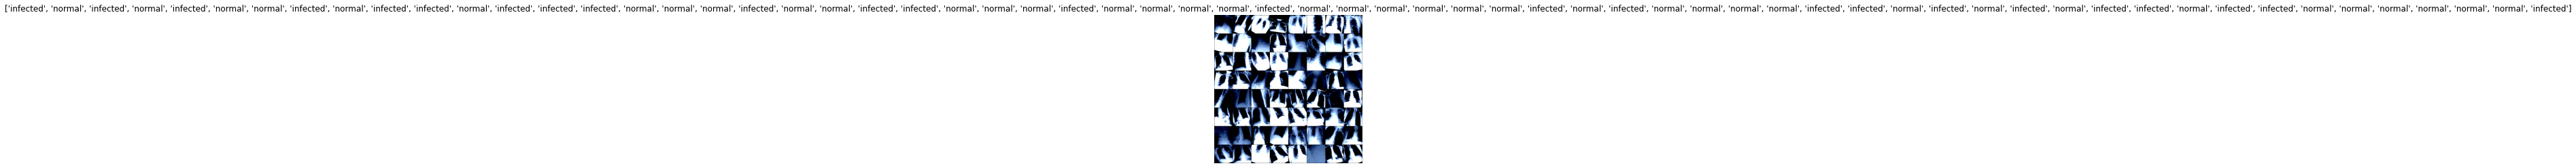

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Task 1


In [8]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Adding New Layer

In [0]:
features=[]
features.extend([nn.Linear(25088, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)

### Loss function and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [13]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.474106: : 188it [21:48,  6.96s/it]
Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.259004: : 188it [01:50,  1.70it/s]
Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.166042: : 188it [01:50,  1.70it/s]
Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.184484: : 188it [01:50,  1.70it/s]
Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.271694: : 188it [01:51,  1.68it/s]
Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.332193: : 188it [01:51,  1.68it/s]
Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.573356: : 188it [01:51,  1.68it/s]
Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.272550: : 188it [01:52,  1.67it/s]
Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.299624: : 188it [01:52,  1.67it/s]
Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.320283: : 188it [01:55,  1.63it/s]


Finished Training


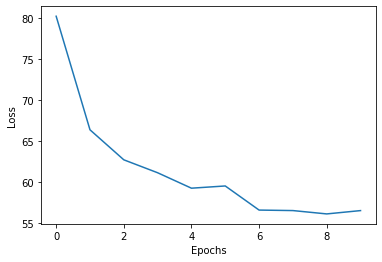

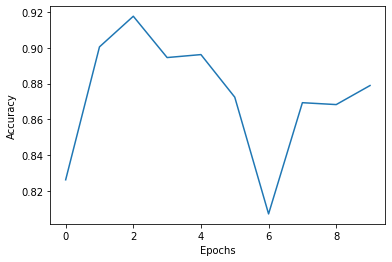

In [14]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


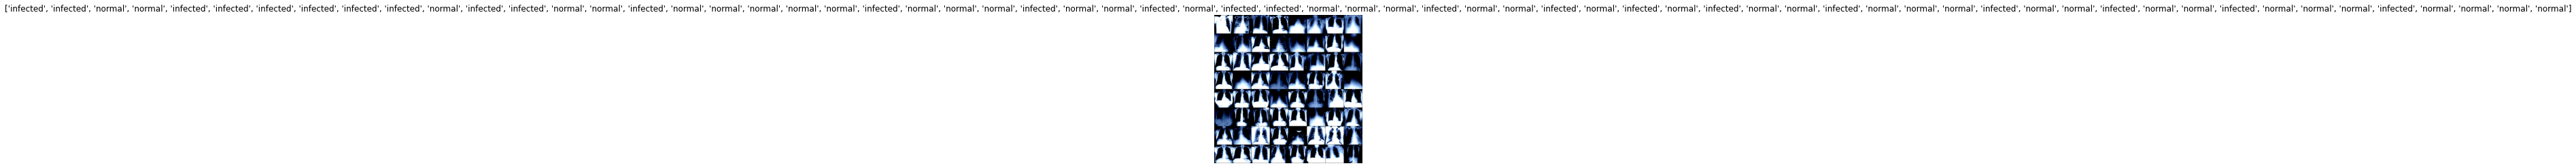

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [16]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal infected infected normal infected normal infected normal infected infected normal normal infected normal normal normal normal normal infected normal normal normal infected normal normal normal normal infected infected normal normal normal infected normal normal infected normal infected normal normal normal normal infected normal normal normal infected normal normal infected normal normal infected normal normal normal infected normal normal normal normal
Ground Truth:  infected infected normal normal infected infected infected infected infected infected normal infected infected normal normal infected normal normal normal normal normal infected normal normal normal infected normal normal infected normal infected infected normal normal normal infected normal normal infected normal infected normal infected normal normal infected normal normal normal infected normal normal infected normal normal infected normal normal normal infected normal normal

In [17]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the test images: 94 %


(array([[546,  69],
        [ 16, 869]]), 0.948744436110621)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


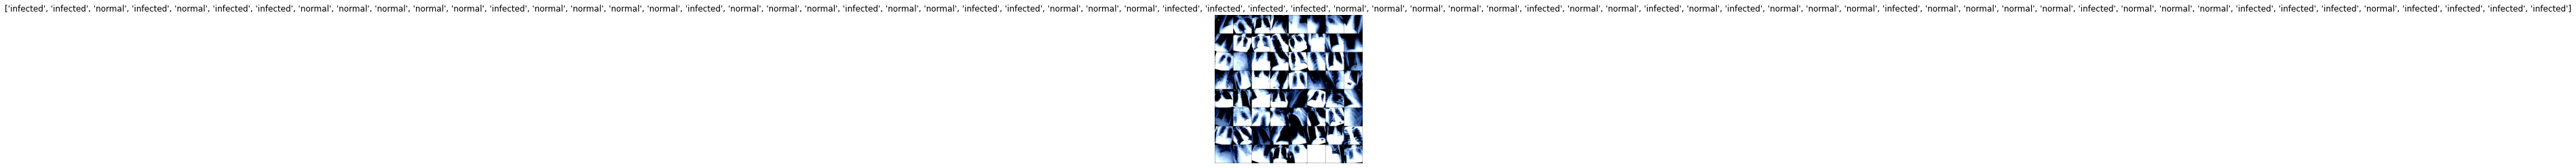

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [19]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal infected normal infected infected normal normal normal normal normal infected infected normal normal normal infected normal normal normal infected normal normal infected normal normal normal normal infected infected normal infected normal normal normal normal normal infected normal normal infected infected infected normal normal normal infected infected normal normal normal infected normal normal normal infected infected infected normal infected infected infected infected
Ground Truth:  infected infected normal infected normal infected infected normal normal normal normal normal infected normal normal normal normal infected normal normal normal infected normal normal infected infected normal normal normal infected infected infected infected normal normal normal normal normal infected normal normal infected normal infected normal normal normal infected normal normal normal normal infected normal normal normal infected infected infected normal infecte

In [20]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 88 %


(array([[4003,  916],
        [ 488, 6593]]), 0.8850260112589963)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


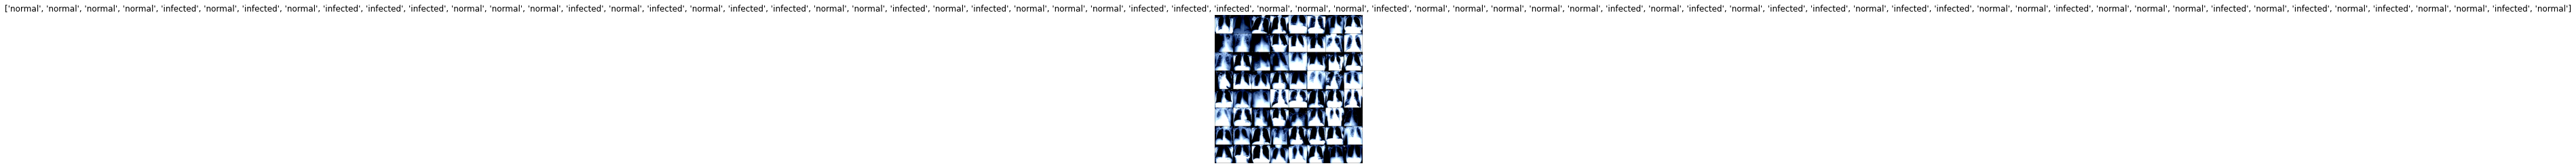

In [21]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [22]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal normal infected infected infected normal normal normal infected normal infected normal infected infected normal normal normal normal infected normal normal normal normal infected infected normal normal normal infected normal normal normal normal normal infected normal infected normal infected infected normal infected infected normal normal infected normal normal normal normal normal infected normal normal normal normal infected infected
Ground Truth:  normal normal normal normal infected normal infected normal infected infected infected normal normal normal infected normal infected normal infected infected normal normal infected normal infected normal normal normal infected infected infected normal normal normal infected normal normal normal normal normal infected normal infected normal infected infected normal infected infected normal normal infected normal normal normal infected normal infected normal infected normal normal

In [23]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 88 %


(array([[514, 101],
        [ 68, 817]]), 0.8839292153114934)

In [0]:
# Load the pretrained model from pytorch
resnet = models.resnet18(pretrained=True)

In [0]:
# Freeze training for all layers
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
features=[]
features.extend([nn.Linear(512, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])

In [0]:
resnet.fc = nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

        
    torch.save(resnet.state_dict(), 'res18_FC_Only.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.700536: : 0it [00:03, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.700536: : 1it [00:03,  3.23s/it]
Train Epoch: 0 [64/12000 (1%)]	Loss: 0.705194: : 1it [00:03,  3.23s/it]
Train Epoch: 0 [64/12000 (1%)]	Loss: 0.705194: : 2it [00:03,  2.32s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.709343: : 2it [00:03,  2.32s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.709343: : 3it [00:03,  1.69s/it]
Train Epoch: 0 [192/12000 (2%)]	Loss: 0.706759: : 3it [00:03,  1.69s/it]
Train Epoch: 0 [192/12000 (2%)]	Loss: 0.706759: : 4it [00:03,  1.24s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.668188: : 4it [00:04,  1.24s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.668188: : 5it [00:04,  1.07it/s]
Train Epoch: 0 [320/12000 (3%)]	Loss: 0.726117: : 5it [00:06,  1.07it/s]
Train Epoch: 0 [320/12000 (3%)]	Loss: 0.726117: : 6it [00:06,  1.40s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.614765: : 6it [00:06,  1.40s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.6

Finished Training


In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


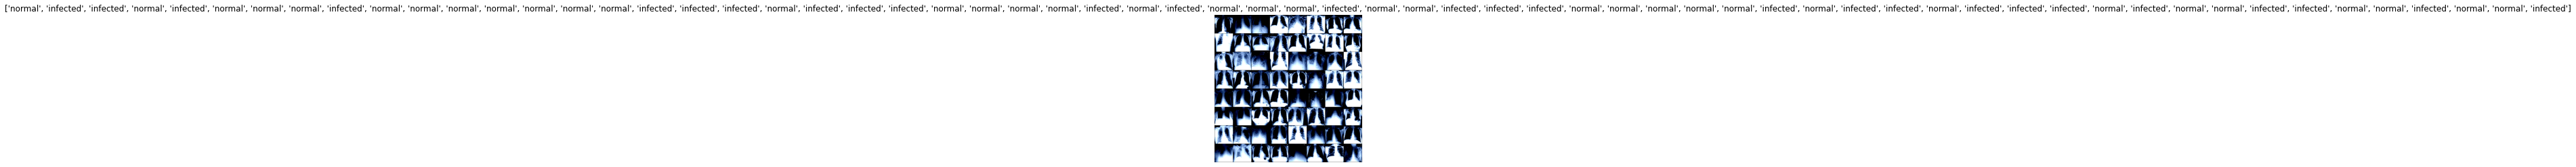

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected infected normal infected normal normal normal infected normal normal normal normal normal normal normal normal infected infected normal infected infected infected normal infected normal normal normal normal infected normal normal infected normal normal normal infected infected normal normal normal normal normal normal infected normal infected infected normal infected infected infected normal infected normal normal infected infected normal normal infected normal normal infected
Ground Truth:  normal infected infected normal infected normal normal normal infected normal normal normal normal normal normal normal infected infected infected normal infected infected infected normal normal normal normal infected normal infected normal normal normal infected normal normal infected infected infected normal normal normal normal normal infected normal infected infected normal infected infected infected normal infected normal normal infected infected normal normal infec

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 90 %


(array([[530,  85],
        [ 54, 831]]), 0.9347149095475235)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


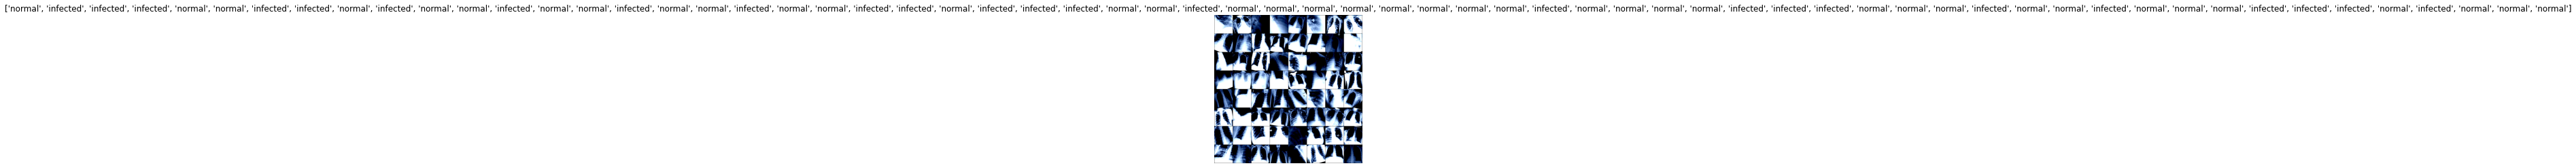

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected infected normal normal normal infected normal normal infected normal normal infected normal normal infected normal normal normal infected infected infected infected normal infected infected infected normal normal infected normal normal normal normal normal normal infected normal infected infected normal normal normal normal infected normal normal normal normal infected normal normal infected normal normal normal infected infected normal infected infected infected normal normal
Ground Truth:  normal infected infected infected normal normal infected infected normal infected normal normal infected normal normal infected normal normal infected normal normal infected infected normal infected infected infected normal normal infected normal normal normal normal normal normal normal normal infected normal normal normal normal infected infected infected normal normal normal infected normal normal infected normal normal normal infected infected infected normal infecte

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 84 %


(array([[3768, 1151],
        [ 650, 6431]]), 0.8464574099067318)

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal infected normal infected normal normal infected normal infected normal normal normal infected normal infected normal infected normal infected infected infected infected normal infected infected normal normal normal infected normal infected normal infected normal normal normal normal normal infected infected normal infected infected infected infected normal infected normal infected infected normal normal normal normal infected normal normal normal normal
Ground Truth:  normal normal normal infected normal normal infected normal infected normal normal infected infected infected normal normal normal infected normal infected normal infected normal infected infected infected infected normal infected infected normal infected infected infected normal infected normal infected normal normal normal normal normal normal infected normal infected infected infected infected normal infected normal infected infected normal normal infected normal in

In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 83 %


(array([[474, 141],
        [107, 778]]), 0.8797366860521152)

###                 Task 02



In [0]:
resnets = models.resnet18(pretrained=True)
vgg16s  = models.vgg16(pretrained=True)

In [0]:
features=[]
features.extend([nn.Linear(512, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])
resnets.fc = nn.Sequential(*features)
features=[]
features.extend([nn.Linear(25088, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])
vgg16s.classifier=nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16s.parameters(), lr=0.001, momentum=0.9)
for param in resnets.parameters():
    param.requires_grad = True
for param in vgg16s.parameters():
    param.requires_grad = True

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16s.to(device)

vgg16s.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16s(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

        
    torch.save(vgg16s.state_dict(), 'vgg16_entire.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.194008: : 110it [01:19,  1.38it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.335584: : 110it [01:20,  1.38it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.335584: : 111it [01:20,  1.29it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.141374: : 111it [01:21,  1.29it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.141374: : 112it [01:21,  1.35it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.206690: : 112it [01:22,  1.35it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.206690: : 113it [01:22,  1.45it/s]


Train Epoch: 5 [7232/12000 (60%)]	Loss: 0.165704: : 113it [01:22,  1.45it/s]


Train Epoch: 5 [7232/12000 (60%)]	Loss: 0.165704: : 114it [01:22,  1.58it/s]


Train Epoch: 5 [7296/12000 (61%)]	Loss: 0.215765: : 114it [01:23,  1.58it/s]


Train Epoch: 5 [7296/12000 (61%)]	Loss: 0.215765: : 115it [01:23,  1.46it/s]


Train Epoch: 5 [7360/12000 (61%)]	Loss: 0.280569: : 115it [01:24,  1.46it/s]



Finished Training


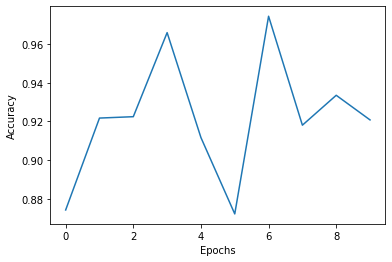

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves

### Testing

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16s(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected infected infected infected normal normal normal infected normal normal normal normal infected normal infected infected infected normal normal normal normal infected infected normal normal infected infected normal infected normal infected normal normal infected normal normal normal infected normal infected normal normal infected infected normal normal normal normal normal normal normal normal infected infected infected infected normal infected infected infected infected infected normal
Ground Truth:  normal infected infected infected infected normal normal infected infected normal normal normal normal infected normal infected infected infected normal normal normal normal infected infected normal normal infected infected normal infected normal infected normal normal infected normal normal normal infected normal infected normal normal infected infected normal normal normal normal normal normal normal normal infected infected infected infected normal infected in

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16s(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 96 %


(array([[570,  45],
        [  4, 881]]), 0.9735066812223391)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


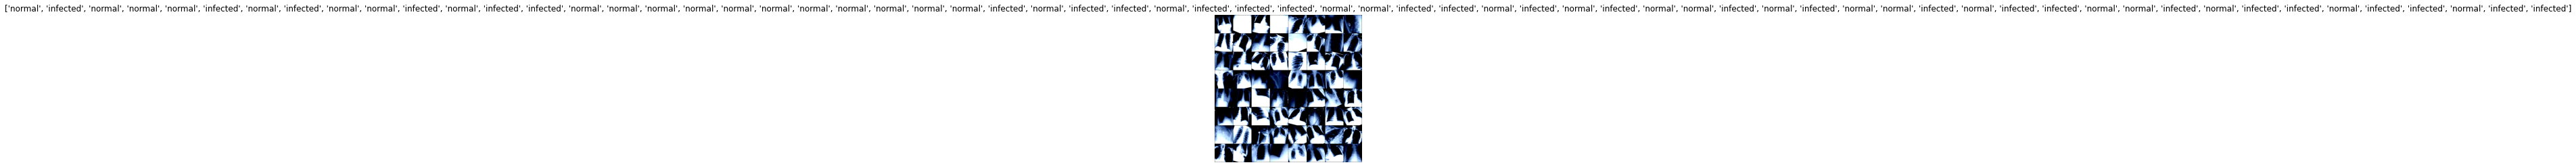

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16s(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal normal normal infected normal infected normal normal infected normal infected infected normal normal normal normal normal normal normal normal normal normal normal infected normal infected infected normal infected infected infected normal normal infected infected normal infected normal infected normal normal infected normal infected normal normal infected normal infected infected normal normal infected normal infected normal normal infected infected normal infected infected
Ground Truth:  normal infected normal normal normal infected normal infected normal normal infected normal infected infected normal normal normal normal normal normal normal normal normal normal normal infected normal infected infected normal infected infected infected normal normal infected infected normal infected normal infected normal normal infected normal infected normal normal infected normal infected infected normal normal infected normal infected infected normal infected i

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16s(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 92 %


(array([[4169,  750],
        [ 168, 6913]]), 0.9450649417081887)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


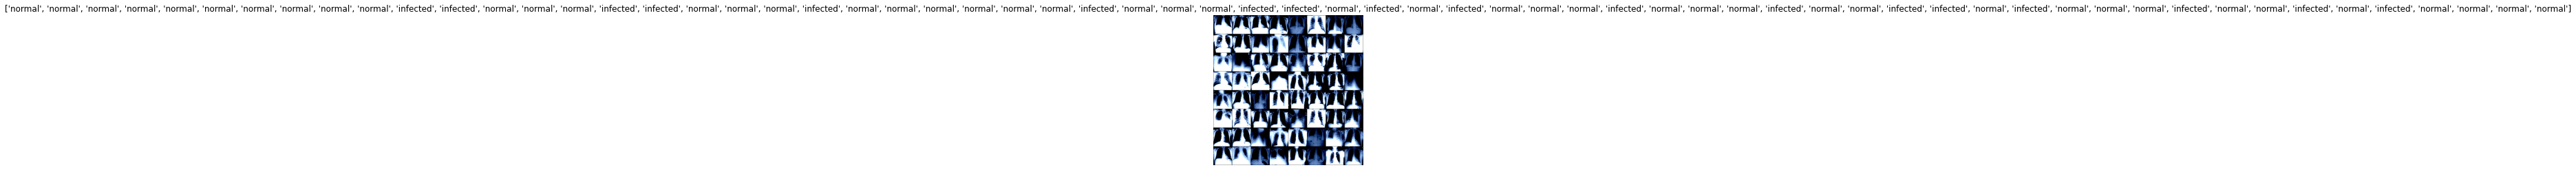

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16s(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal normal normal normal normal infected normal normal normal infected infected normal normal normal infected normal normal normal normal normal normal infected normal normal normal infected normal normal infected normal infected normal normal normal infected normal normal normal infected normal normal infected infected normal infected normal normal normal infected normal normal infected normal infected normal normal normal normal
Ground Truth:  normal normal normal normal normal normal normal normal normal normal infected infected normal normal normal infected infected normal normal normal infected normal normal normal normal normal normal infected normal normal normal infected infected normal infected normal infected normal normal normal infected normal normal normal infected normal normal infected infected normal infected normal normal normal infected normal normal infected normal infected normal normal normal normal


In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16s(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 91 %


(array([[516,  99],
        [ 34, 851]]), 0.9410218510526115)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnets.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnets.to(device)

resnets.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnets(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

        
    torch.save(resnets.state_dict(), 'res18_entire.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.


Train Epoch: 5 [6848/12000 (57%)]	Loss: 0.124862: : 107it [01:10,  1.16it/s]


Train Epoch: 5 [6848/12000 (57%)]	Loss: 0.124862: : 108it [01:10,  1.56it/s]


Train Epoch: 5 [6912/12000 (57%)]	Loss: 0.268653: : 108it [01:11,  1.56it/s]


Train Epoch: 5 [6912/12000 (57%)]	Loss: 0.268653: : 109it [01:11,  2.03it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.172892: : 109it [01:11,  2.03it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.172892: : 110it [01:11,  2.57it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.236361: : 110it [01:12,  2.57it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.236361: : 111it [01:12,  1.24it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.156651: : 111it [01:13,  1.24it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.156651: : 112it [01:13,  1.25it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.227819: : 112it [01:13,  1.25it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.227819: : 113it [01:13,  1.66it/s]



Finished Training


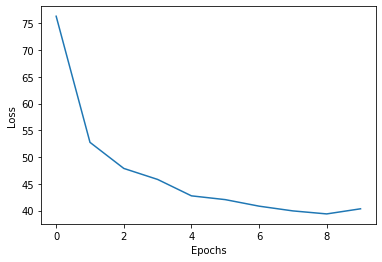

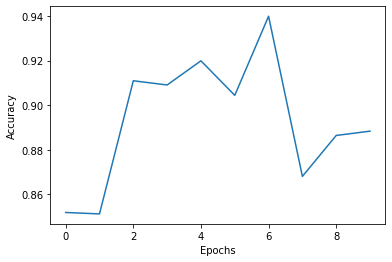

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


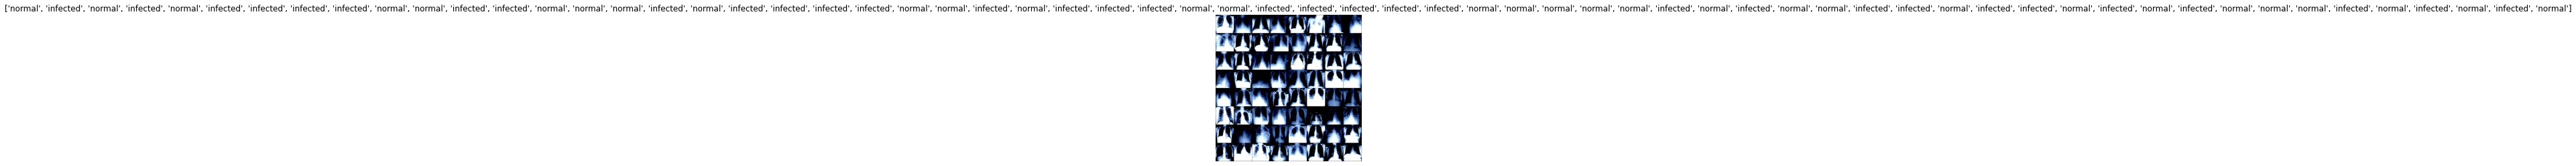

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnets(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal infected normal infected infected infected infected normal normal infected infected normal normal normal infected normal infected infected infected infected normal normal infected normal infected infected infected normal normal infected infected infected infected normal normal normal normal normal normal infected normal infected normal normal infected infected normal infected infected normal infected normal infected normal normal normal infected normal infected normal infected normal
Ground Truth:  normal infected normal infected normal infected infected infected infected normal normal infected infected normal normal normal infected normal infected infected infected infected normal normal infected normal infected infected infected normal normal infected infected infected infected infected normal normal normal normal normal infected normal infected normal normal infected infected normal infected infected normal infected normal infected normal normal no

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnets(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 96 %


(array([[575,  40],
        [ 14, 871]]), 0.9202959846947847)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


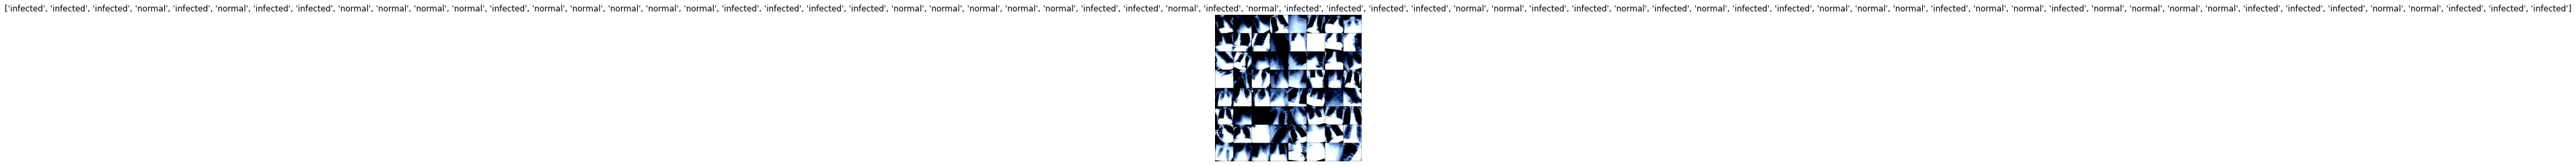

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnets(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected infected normal infected normal normal infected normal normal normal normal infected normal normal normal normal normal infected infected infected infected normal normal infected normal normal infected infected normal normal normal infected infected infected infected normal normal infected normal normal infected normal infected infected normal normal normal infected normal infected normal normal normal normal normal infected infected infected infected normal infected infected normal
Ground Truth:  infected infected infected normal infected normal infected infected normal normal normal normal infected normal normal normal normal normal infected infected infected infected normal normal normal normal normal infected infected normal infected normal infected infected infected infected normal normal infected infected normal infected normal infected infected normal normal normal infected normal normal infected normal normal normal normal infected infected infected 

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnets(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 91 %


(array([[4283,  636],
        [ 344, 6737]]), 0.8908408693404202)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


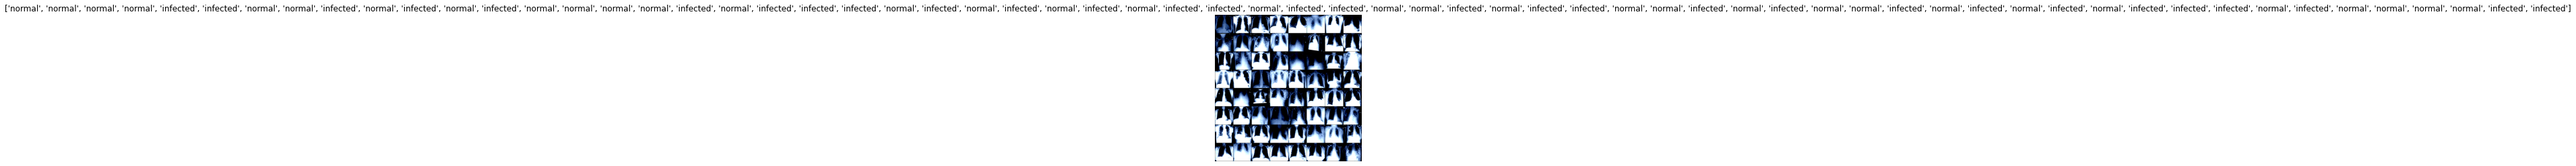

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnets(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal infected normal normal infected normal infected normal infected normal normal normal normal infected normal infected infected infected normal infected normal infected normal infected infected infected normal normal normal infected normal infected infected normal normal infected normal normal infected normal normal normal normal infected normal infected normal infected normal infected infected infected normal infected normal normal normal normal infected infected
Ground Truth:  normal normal normal normal infected infected normal normal infected normal infected normal infected normal normal normal normal infected normal infected infected infected normal infected normal infected normal infected normal infected infected normal infected infected normal normal infected normal infected infected normal normal infected normal infected normal normal infected normal infected normal infected normal infected infected infected normal infected normal no

In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnets(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 90 %


(array([[537,  78],
        [ 62, 823]]), 0.9525192547851113)

In [0]:
res = models.resnet18(pretrained=True)
vgg  = models.vgg16(pretrained=True)

In [0]:
features=[]
features.extend([nn.Linear(512, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])
res.fc = nn.Sequential(*features)
features=[]
features.extend([nn.Linear(25088, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])
vgg.classifier=nn.Sequential(*features)

In [0]:
for param in res.layer4: #freeze last layer
  param.requires_grad = False

In [0]:
count=0 # freeze last 10
for param in vgg.features:
  if(count>20):
    param.requires_grad = False
  count+=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg.to(device)

vgg.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.159318: : 109it [01:21,  1.40it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.159318: : 110it [01:21,  1.55it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.229820: : 110it [01:21,  1.55it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.229820: : 111it [01:21,  1.62it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.165013: : 111it [01:23,  1.62it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.165013: : 112it [01:23,  1.15it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.274701: : 112it [01:23,  1.15it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.274701: : 113it [01:23,  1.30it/s]


Train Epoch: 5 [7232/12000 (60%)]	Loss: 0.209070: : 113it [01:24,  1.30it/s]


Train Epoch: 5 [7232/12000 (60%)]	Loss: 0.209070: : 114it [01:24,  1.45it/s]


Train Epoch: 5 [7296/12000 (61%)]	Loss: 0.322185: : 114it [01:24,  1.45it/s]


Train Epoch: 5 [7296/12000 (61%)]	Loss: 0.322185: : 115it [01:24,  1.56it/s]


T

Finished Training


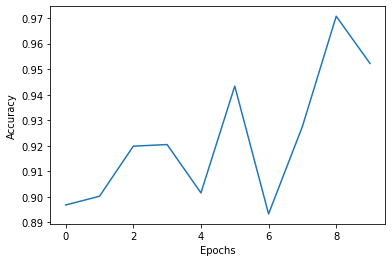

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


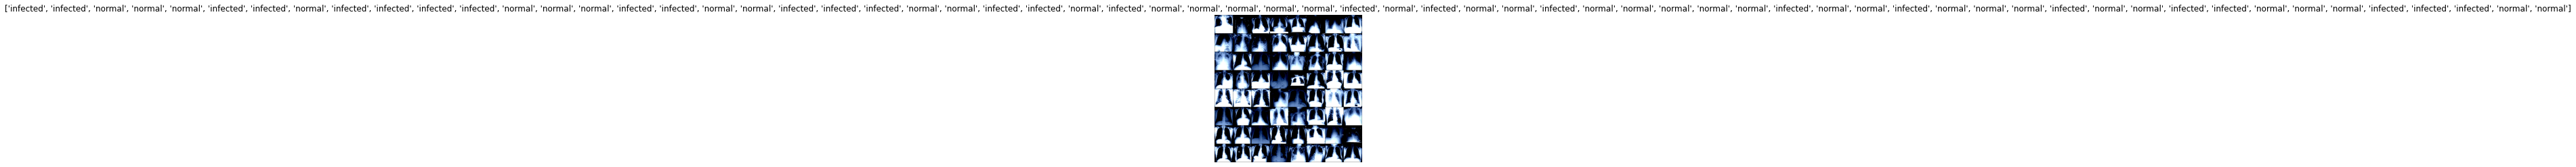

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal normal infected normal normal infected infected infected infected normal normal normal normal infected normal normal infected infected infected normal infected infected infected normal infected normal normal normal normal normal infected normal infected normal normal infected normal normal normal normal normal infected normal normal infected normal normal normal normal normal normal infected infected normal normal normal infected infected infected normal normal
Ground Truth:  infected infected normal normal normal infected infected normal infected infected infected infected normal normal normal infected infected normal normal infected infected infected normal normal infected infected normal infected normal normal normal normal normal infected normal infected normal normal infected normal normal normal normal normal infected normal normal infected normal normal normal infected normal normal infected infected normal normal normal infected infec

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 96 %


(array([[559,  56],
        [  3, 882]]), 0.982442091802088)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


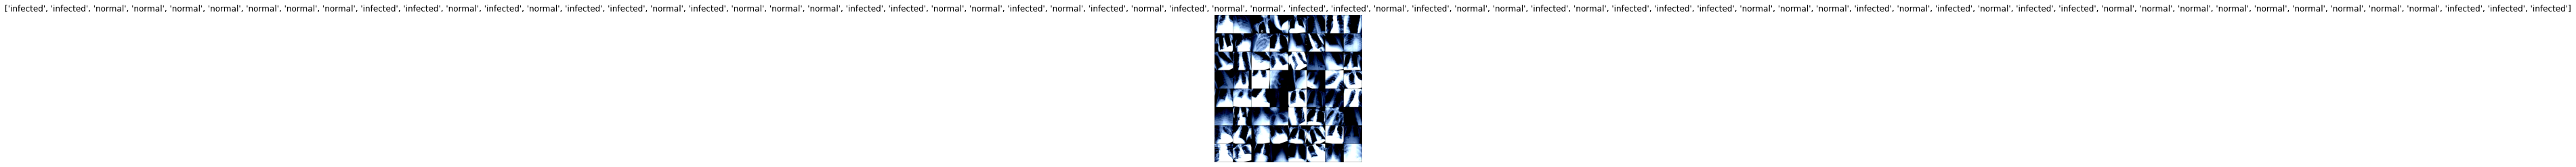

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal normal normal normal normal normal infected infected normal normal normal infected infected normal infected normal normal normal infected infected normal normal infected normal infected normal infected normal normal infected infected normal infected normal normal infected normal infected infected infected normal normal normal infected normal infected normal infected infected normal normal normal normal normal normal normal normal normal infected infected infected
Ground Truth:  infected infected normal normal normal normal normal normal normal infected infected normal infected normal infected infected normal infected normal normal normal infected infected normal normal infected normal infected normal infected normal normal infected infected normal infected normal normal infected normal infected infected infected normal normal normal infected normal infected normal infected infected normal normal normal normal normal normal normal normal norma

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 91 %


(array([[3984,  935],
        [ 107, 6974]]), 0.9124263796045832)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


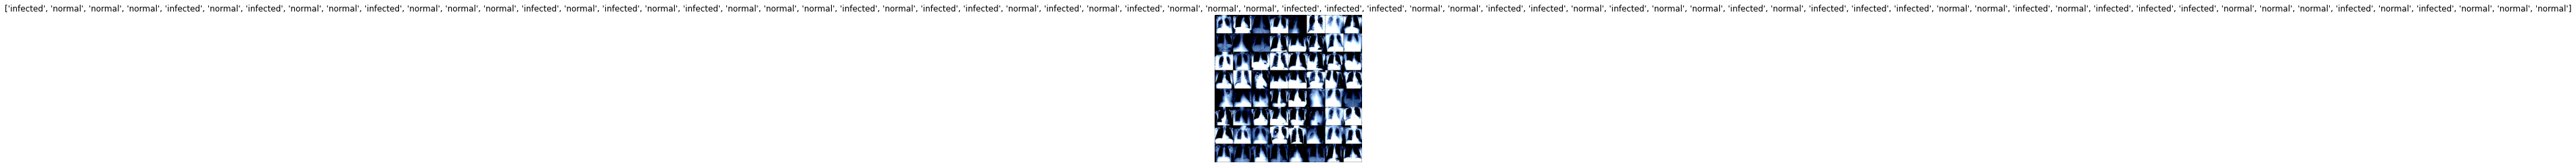

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal normal infected normal infected normal normal infected normal normal normal infected normal infected normal infected normal normal normal infected normal infected normal normal infected normal normal normal normal normal infected normal normal normal normal infected infected normal infected normal normal infected normal infected infected normal normal normal infected normal infected infected normal normal normal normal infected normal infected normal normal normal
Ground Truth:  infected normal normal normal infected normal infected normal normal infected normal normal normal infected normal infected normal infected normal normal normal infected normal infected infected normal infected normal infected normal normal normal infected infected infected normal normal infected infected normal infected normal normal infected normal infected infected infected normal normal infected normal infected infected infected normal normal normal infected normal infecte

In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 90 %


(array([[488, 127],
        [ 21, 864]]), 0.9327960409065976)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res.to(device)

res.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = res(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 5 [6784/12000 (56%)]	Loss: 0.233352: : 107it [01:10,  1.16it/s]


Train Epoch: 5 [6848/12000 (57%)]	Loss: 0.145866: : 107it [01:10,  1.16it/s]


Train Epoch: 5 [6848/12000 (57%)]	Loss: 0.145866: : 108it [01:10,  1.55it/s]


Train Epoch: 5 [6912/12000 (57%)]	Loss: 0.209751: : 108it [01:11,  1.55it/s]


Train Epoch: 5 [6912/12000 (57%)]	Loss: 0.209751: : 109it [01:11,  2.03it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.316355: : 109it [01:11,  2.03it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.316355: : 110it [01:11,  2.62it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.176238: : 110it [01:13,  2.62it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.176238: : 111it [01:13,  1.00s/it]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.222574: : 111it [01:13,  1.00s/it]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.222574: : 112it [01:13,  1.24it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.143418: : 112it [01:14,  1.24it/s]


T

Finished Training


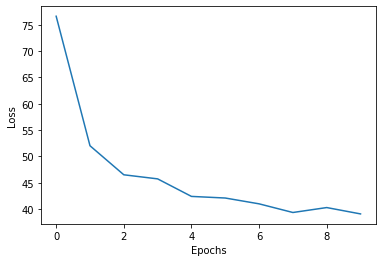

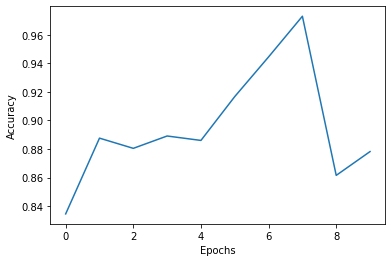

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


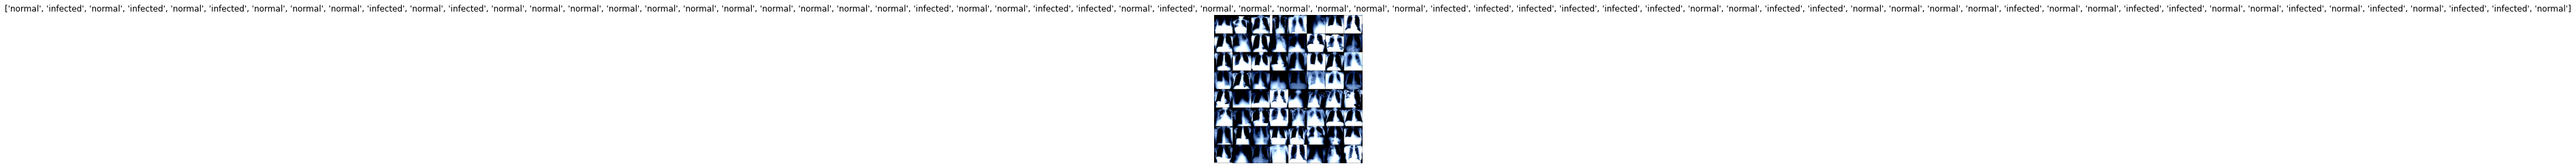

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = res(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal infected normal infected normal normal normal infected normal infected normal normal normal normal normal normal normal normal normal normal normal infected normal normal normal infected normal infected normal normal normal infected normal normal infected infected infected infected infected infected normal normal infected infected normal normal normal normal infected normal normal normal normal normal normal infected normal infected normal normal infected normal
Ground Truth:  normal infected normal infected normal infected normal normal normal infected normal infected normal normal normal normal normal normal normal normal normal normal normal infected normal normal infected infected normal infected normal normal normal normal normal normal infected infected infected infected infected infected normal normal infected infected normal normal normal normal infected normal normal infected infected normal normal infected normal infected normal infected inf

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 96 %


(array([[576,  39],
        [ 12, 873]]), 0.9892312249292441)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


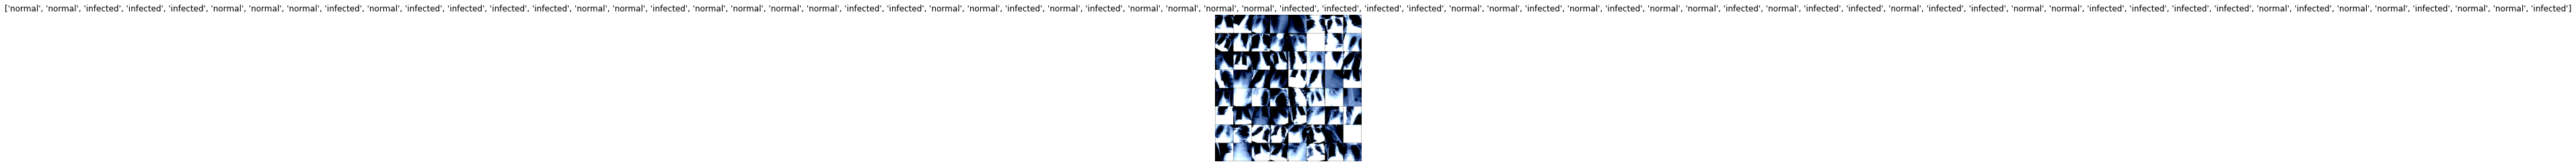

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = res(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected infected infected normal normal normal normal normal normal infected infected infected normal normal infected normal normal normal normal infected infected normal normal infected normal infected normal normal normal normal infected infected infected normal normal normal infected normal normal normal normal infected normal infected infected normal infected infected normal normal infected infected infected infected normal infected normal normal infected normal normal infected
Ground Truth:  normal normal infected infected infected normal normal normal infected normal infected infected infected infected normal normal infected normal normal normal normal infected infected normal normal infected normal infected normal normal normal normal infected infected infected infected normal normal infected normal infected normal normal infected normal infected infected normal infected infected normal normal infected infected infected infected normal infected normal 

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 92 %


(array([[4391,  528],
        [ 404, 6677]]), 0.9707587907581268)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


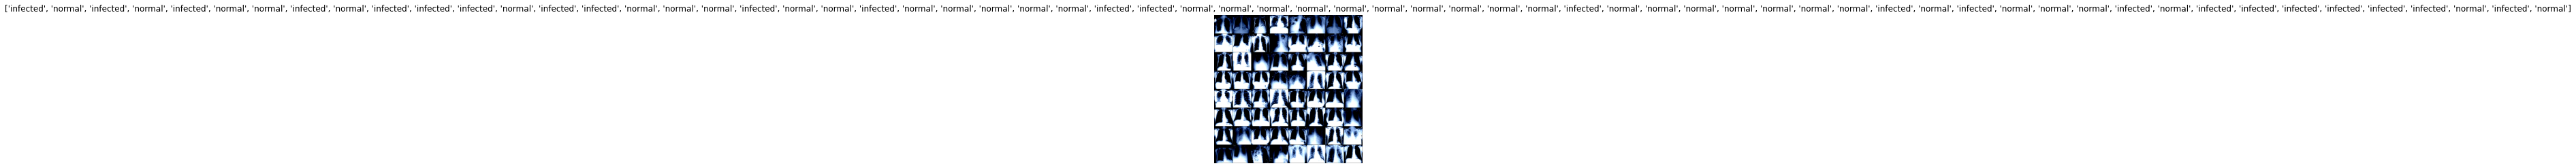

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = res(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected normal infected infected normal infected normal infected infected infected normal infected infected normal normal normal infected infected normal infected normal normal normal normal normal infected infected normal normal normal normal infected normal normal normal normal normal infected normal normal normal normal normal normal normal infected normal infected normal normal normal infected normal infected normal infected infected infected infected normal infected normal
Ground Truth:  infected normal infected normal infected normal normal infected normal infected infected infected normal infected infected normal normal normal infected normal normal infected normal normal normal normal normal infected infected normal normal normal normal normal normal normal normal normal normal infected normal normal normal normal normal normal normal infected normal infected normal normal normal infected normal infected infected infected infected infected infected 

In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 90 %


(array([[542,  73],
        [ 72, 813]]), 0.9128628866516862)

In [0]:
res = models.resnet18(pretrained=True)
vgg  = models.vgg16(pretrained=True)

In [0]:
features=[]
features.extend([nn.Linear(512, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])
res.fc = nn.Sequential(*features)
features=[]
features.extend([nn.Linear(25088, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])
vgg.classifier=nn.Sequential(*features)

In [0]:
for param in res.layer4: #freeze last layer
  param.requires_grad = False
for param in res.layer3: #freeze 2nd last layer
  param.requires_grad = False

In [0]:
count=0 # freeze last 20
for param in vgg.features:
  if(count>10):
    param.requires_grad = False
  count+=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg.to(device)

vgg.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.187144: : 109it [01:22,  1.22it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.187144: : 110it [01:22,  1.37it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.198708: : 110it [01:22,  1.37it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.198708: : 111it [01:22,  1.50it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.208366: : 111it [01:23,  1.50it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.208366: : 112it [01:23,  1.41it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.180041: : 112it [01:24,  1.41it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.180041: : 113it [01:24,  1.33it/s]


Train Epoch: 5 [7232/12000 (60%)]	Loss: 0.266795: : 113it [01:25,  1.33it/s]


Train Epoch: 5 [7232/12000 (60%)]	Loss: 0.266795: : 114it [01:25,  1.28it/s]


Train Epoch: 5 [7296/12000 (61%)]	Loss: 0.223526: : 114it [01:25,  1.28it/s]


Train Epoch: 5 [7296/12000 (61%)]	Loss: 0.223526: : 115it [01:25,  1.41it/s]


T

Finished Training


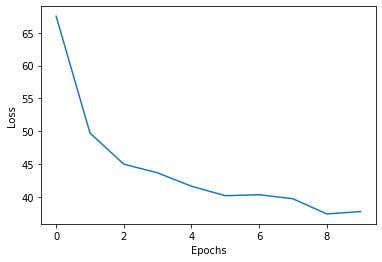

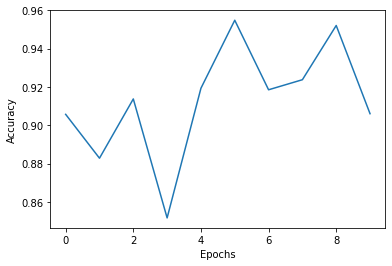

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


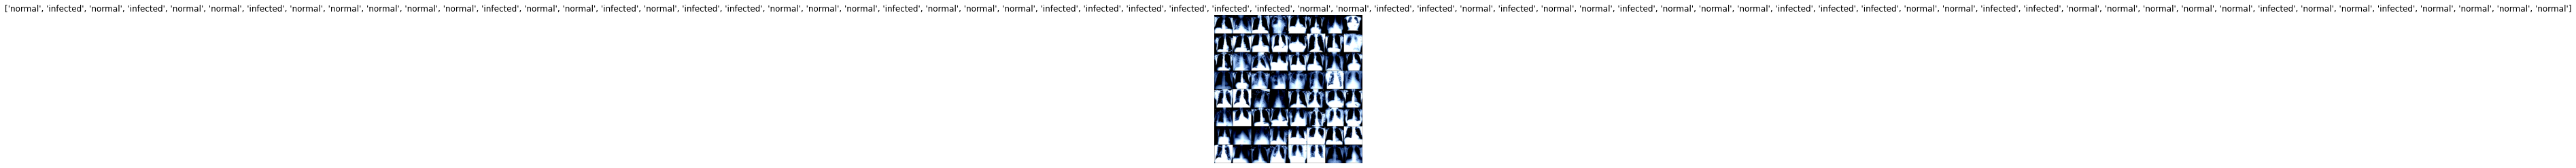

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal infected normal normal infected normal normal normal normal normal infected normal normal infected normal infected infected normal normal normal infected normal normal normal infected infected infected infected infected infected normal normal infected infected normal infected normal normal infected normal normal normal infected infected infected normal normal infected infected normal normal normal normal normal normal normal normal infected normal normal normal normal
Ground Truth:  normal infected normal infected normal normal infected normal normal normal normal normal infected normal normal infected normal infected infected normal normal normal infected normal normal normal infected infected infected infected infected infected normal normal infected infected normal infected normal normal infected normal normal normal infected infected infected normal normal infected infected normal normal normal normal normal infected normal normal infected normal 

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 97 %


(array([[574,  41],
        [  4, 881]]), 0.9562134256294978)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


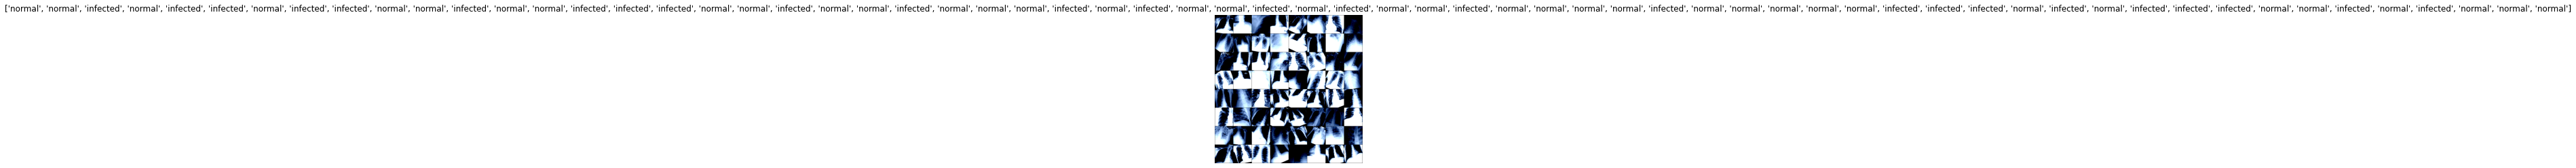

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal infected infected normal infected infected normal normal infected normal normal infected infected infected normal normal infected normal normal infected normal normal normal infected normal infected normal normal infected normal infected normal normal infected normal normal normal normal infected normal normal normal normal normal infected infected infected normal infected normal infected infected infected normal normal normal normal infected normal normal normal
Ground Truth:  normal normal infected normal infected infected normal infected infected normal normal infected normal normal infected infected infected normal normal infected normal normal infected normal normal normal infected normal infected normal normal infected normal infected normal normal infected normal normal normal normal infected normal normal normal normal normal infected infected infected normal infected normal infected infected infected normal normal infected normal infecte

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 92 %


(array([[4156,  763],
        [ 144, 6937]]), 0.8894895197098847)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


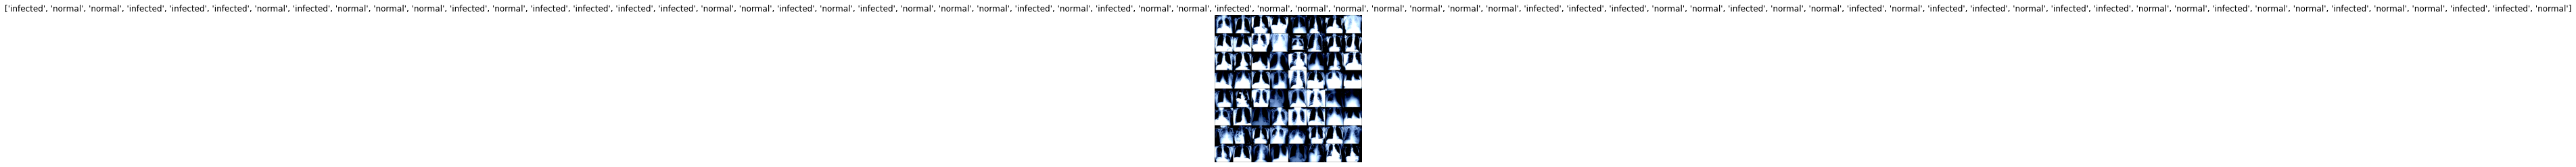

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal normal normal normal normal infected normal normal normal infected normal infected normal normal infected normal normal infected normal normal normal normal normal infected normal infected normal normal infected normal normal normal normal normal normal normal infected infected infected normal normal infected normal normal infected normal infected infected normal infected infected normal normal infected normal normal infected normal normal infected infected normal
Ground Truth:  infected normal normal infected infected infected normal infected normal normal normal infected normal infected infected infected infected normal normal infected normal infected normal normal normal infected normal infected normal normal infected normal normal normal normal normal normal normal infected infected infected normal normal infected normal normal infected normal infected infected normal infected infected normal normal infected normal normal infected normal normal in

In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 91 %


(array([[521,  94],
        [ 37, 848]]), 0.9495896288278434)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res.to(device)

res.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc=0.0
    #valid_loss=0.0
    #valid_acc=0.0
    pbar = tqdm(enumerate(trainloader))
    #vall=tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = res(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        outputs=torch.argmax(outputs, dim=1)
        running_acc=(running_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    # for i, data in vall:
    #     inputs, labels = data
    #     inputs, labels = inputs.to(device), labels.to(device)
    #     outputs = vgg16(inputs)               #----> forward pass
    #     loss = criterion(outputs, labels)
    #     valid_loss+=loss
    #     outputs=torch.argmax(outputs, dim=1)
    #     valid_acc=(valid_acc+accuracy_score(labels.cpu().data.numpy(), outputs.cpu().data.numpy()))/2
    # vacc.append(valid_acc)
    tacc.append(running_acc)
    # vloss.append(valid_loss)
    tloss.append(running_loss)

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 5 [6784/12000 (56%)]	Loss: 0.243271: : 107it [01:10,  1.45it/s]


Train Epoch: 5 [6848/12000 (57%)]	Loss: 0.254025: : 107it [01:10,  1.45it/s]


Train Epoch: 5 [6848/12000 (57%)]	Loss: 0.254025: : 108it [01:10,  1.91it/s]


Train Epoch: 5 [6912/12000 (57%)]	Loss: 0.275617: : 108it [01:12,  1.91it/s]


Train Epoch: 5 [6912/12000 (57%)]	Loss: 0.275617: : 109it [01:12,  1.47it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.237476: : 109it [01:12,  1.47it/s]


Train Epoch: 5 [6976/12000 (58%)]	Loss: 0.237476: : 110it [01:12,  1.90it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.211458: : 110it [01:14,  1.90it/s]


Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.211458: : 111it [01:14,  1.09it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.138612: : 111it [01:14,  1.09it/s]


Train Epoch: 5 [7104/12000 (59%)]	Loss: 0.138612: : 112it [01:14,  1.47it/s]


Train Epoch: 5 [7168/12000 (60%)]	Loss: 0.245606: : 112it [01:14,  1.47it/s]


T

Finished Training


In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()
  #Curves
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


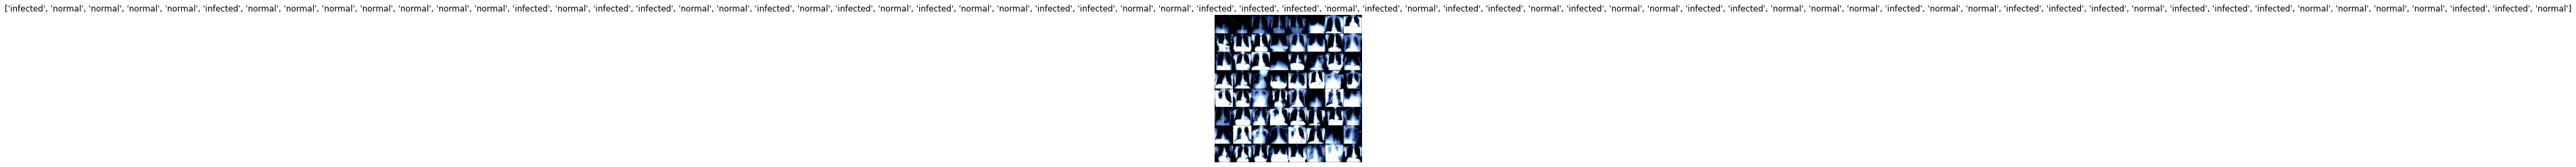

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = res(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal normal infected normal normal normal normal normal normal normal infected normal infected infected normal normal infected normal infected normal infected normal normal infected infected normal normal infected infected infected normal infected normal infected infected normal infected normal normal infected infected normal normal normal infected normal normal infected infected infected normal infected infected infected normal normal normal normal infected infected normal
Ground Truth:  infected normal normal normal normal infected normal normal normal normal normal normal normal infected normal infected infected normal normal infected normal infected normal infected normal normal infected infected normal normal infected infected infected normal infected normal infected infected normal infected normal normal infected infected normal normal normal infected normal normal infected infected infected normal infected infected infected normal normal no

In [0]:
confuse=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse=confuse+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
confuse,f10

Accuracy of the network on the test images: 96 %


(array([[572,  43],
        [ 17, 868]]), 0.9710680488199116)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


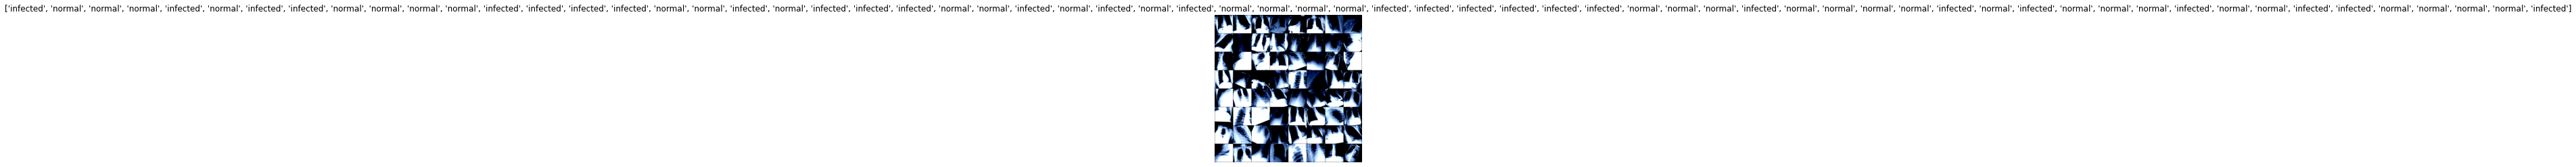

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = res(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal normal infected normal infected infected normal normal normal normal infected infected infected infected normal normal normal normal infected infected infected normal normal infected normal infected normal normal normal normal normal normal infected infected infected infected normal infected normal normal normal infected normal normal normal normal infected infected infected normal normal normal infected normal normal infected infected normal normal infected normal infected
Ground Truth:  infected normal normal normal infected normal infected infected normal normal normal normal infected infected infected infected normal normal infected normal infected infected infected normal normal infected normal infected normal infected normal normal normal normal infected infected infected infected infected infected normal normal normal infected normal normal normal normal infected normal infected normal normal normal infected normal normal infected infected norm

In [0]:
confuse1=np.zeros((2,2),dtype=int)
correct = 0
total = 0
f11=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f11=(f11+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse1=confuse1+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f11

Accuracy of the network on the train images: 91 %


(array([[4305,  614],
        [ 355, 6726]]), 0.9542740248618062)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


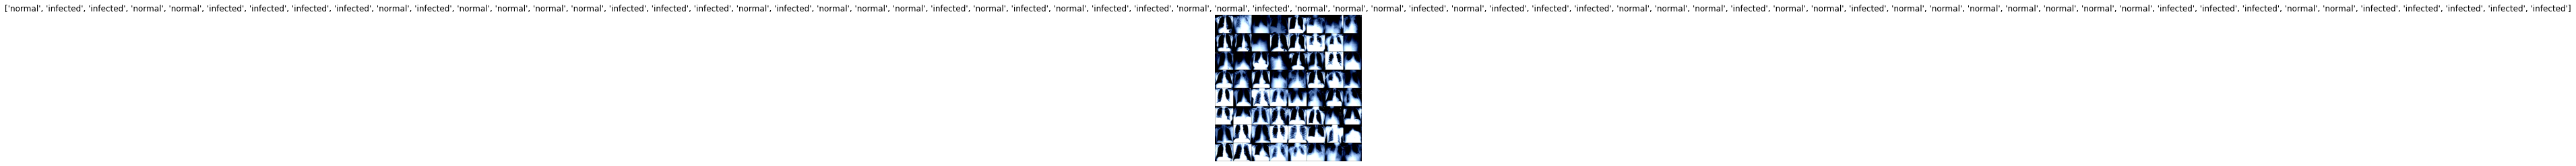

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = res(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal normal normal infected infected infected normal normal infected normal normal normal infected infected infected infected normal infected normal normal normal infected normal infected normal infected infected normal infected infected normal normal normal normal normal infected normal infected normal normal normal infected normal normal infected normal normal normal normal normal normal normal normal infected normal normal normal infected infected infected infected infected
Ground Truth:  normal infected infected normal normal infected infected infected infected normal infected normal normal normal normal infected infected infected normal infected normal normal normal infected normal infected normal infected infected normal normal infected normal normal normal infected normal infected infected infected normal normal normal infected normal normal infected normal normal normal normal normal normal normal infected infected infected normal normal infected i

In [0]:
confuse2=np.zeros((2,2),dtype=int)
f12=0
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f12=(f12+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="binary"))/2
        confuse2=confuse2+confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse2,f12

Accuracy of the network on the validation images: 90 %


(array([[542,  73],
        [ 66, 819]]), 0.8720088200765641)